In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Admission_Predict.csv to Admission_Predict.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error

# 1. Load Data
df = pd.read_csv('Admission_Predict.csv')

# Drop Serial No. as it is just an index
if 'Serial No.' in df.columns:
    df = df.drop('Serial No.', axis=1)

X = df.drop('Chance of Admit ', axis=1) # Note the space in column name
y = df['Chance of Admit ']

# 2. Preprocessing (Scaling is MANDATORY for Lasso/Ridge)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 4. Initialize Models
models = {
    "Multi-Linear": LinearRegression(),
    "Lasso (L1)": Lasso(alpha=0.01), # Small alpha for demonstration
    "Ridge (L2)": Ridge(alpha=1.0)
}

# 5. Train and Evaluate
results = {}
print(f"{'Model':<15} | {'R2 Score':<10} | {'MSE':<10}")
print("-" * 40)

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = r2
    print(f"{name:<15} | {r2:.4f}     | {mse:.4f}")

Model           | R2 Score   | MSE       
----------------------------------------
Multi-Linear    | 0.8212     | 0.0046
Lasso (L1)      | 0.7966     | 0.0053
Ridge (L2)      | 0.8209     | 0.0046


In [ ]:
from sklearn.model_selection import GridSearchCV

# --- TUNING LASSO ---
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]}
lasso_search = GridSearchCV(Lasso(), lasso_params, cv=5, scoring='r2')
lasso_search.fit(X_train, y_train)

print("--- Lasso Tuning ---")
print(f"Best Alpha: {lasso_search.best_params_['alpha']}")
print(f"Best R2: {lasso_search.best_score_:.4f}")

# --- TUNING RIDGE ---
ridge_params = {'alpha': [0.1, 1.0, 10.0, 100.0, 200.0]}
ridge_search = GridSearchCV(Ridge(), ridge_params, cv=5, scoring='r2')
ridge_search.fit(X_train, y_train)

print("\n--- Ridge Tuning ---")
print(f"Best Alpha: {ridge_search.best_params_['alpha']}")
print(f"Best R2: {ridge_search.best_score_:.4f}")

--- Lasso Tuning ---
Best Alpha: 0.001
Best R2: 0.7823

--- Ridge Tuning ---
Best Alpha: 10.0
Best R2: 0.7808


In [ ]:
# Evaluate the best models on the Test Set
print("--- Final Test Set Evaluation ---")

# 1. Get the best Lasso model found by GridSearch
best_lasso = lasso_search.best_estimator_
lasso_test_score = best_lasso.score(X_test, y_test)
print(f"Lasso Test Score: {lasso_test_score:.4f}")

# 2. Get the best Ridge model found by GridSearch
best_ridge = ridge_search.best_estimator_
ridge_test_score = best_ridge.score(X_test, y_test)
print(f"Ridge Test Score: {ridge_test_score:.4f}")

--- Final Test Set Evaluation ---
Lasso Test Score: 0.8192
Ridge Test Score: 0.8181


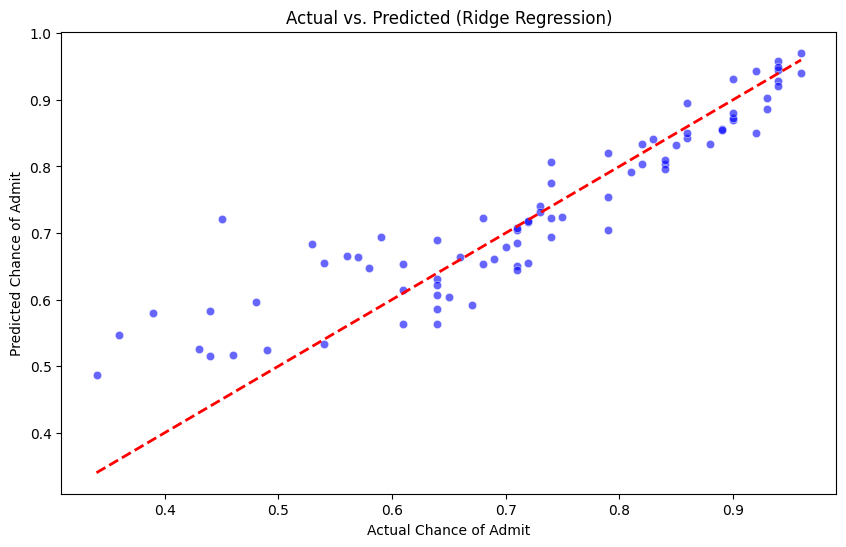

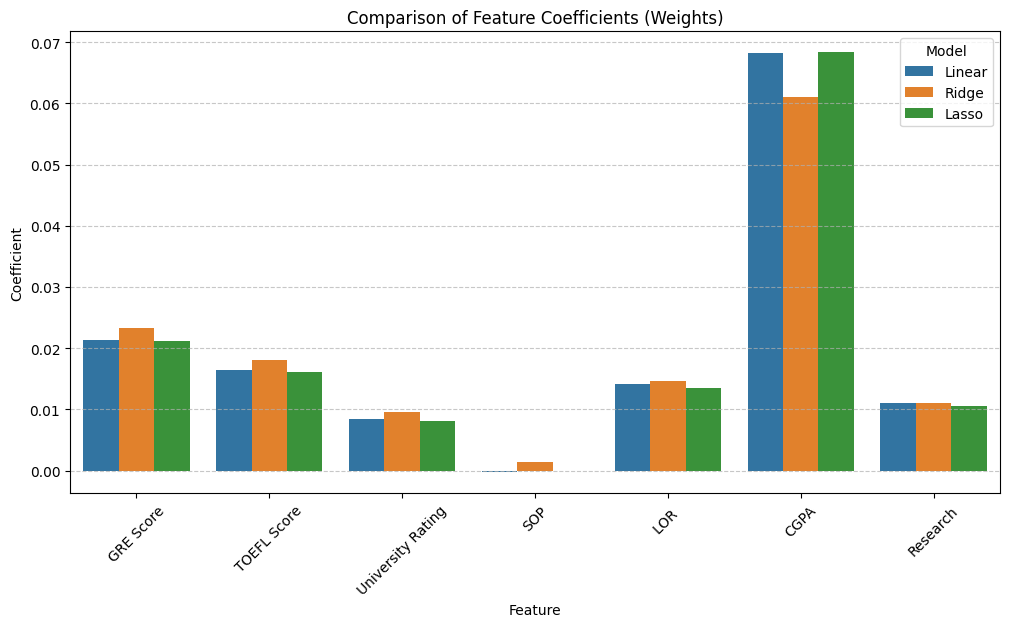

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- VISUALIZATION 1: Actual vs. Predicted (For the Best Model) ---
plt.figure(figsize=(10, 6))
# Using the best Ridge model from your tuning
y_pred_best = best_ridge.predict(X_test)

sns.scatterplot(x=y_test, y=y_pred_best, color='blue', alpha=0.6)
# Draw the "Perfect Fit" line (Diagonal)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Chance of Admit")
plt.ylabel("Predicted Chance of Admit")
plt.title("Actual vs. Predicted (Ridge Regression)")
plt.show()

# --- VISUALIZATION 2: Feature Importance Comparison ---
# This shows how different models weight the features
feature_names = df.drop('Chance of Admit ', axis=1).columns

# Create a DataFrame of coefficients
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Linear': models['Multi-Linear'].coef_,
    'Ridge': best_ridge.coef_,
    'Lasso': best_lasso.coef_
})

# Melt for plotting
coef_melted = coef_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')

plt.figure(figsize=(12, 6))
sns.barplot(data=coef_melted, x='Feature', y='Coefficient', hue='Model')
plt.title("Comparison of Feature Coefficients (Weights)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()